# INM707 Coursework Task 3
### Aaron Mir (Student Number: 160001207)
## DDPG Implementation on Lunar Lander Environment

In [ ]:
##--------------------Coding References---------------------## 
# Percentage of borrowed code: 10% - DDPG Implementation inspired by Spinning Up implementation
# [1] Spinning Up (2020) DDPG, 
# Available at: https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/ddpg (Accessed: 29th March 2021).

In [21]:
import gym
import numpy as np 
import torch
from stronghold.ddpg import ddpg_train_val, test_agent
import pickle
import matplotlib.pyplot as plt
from IPython.display import HTML

***
## Lunar Lander

The environment is defined as follows:

- The goal is to land the lunar module on the moon between the flags without crashing. The state vector is eight dimensional and contains: [x_pos, y_pos, x_vel, y_vel, lander_angle, lander_angular_vel, leftleg ground_contact_flag, right_leg_ground_contact_flag]. 

- The landing pad coordinates are always at 0, 0 and are the first two numbers in the state vector.

- There are two possible actions which take float values [main engine, left-right engines].

    - Main engine: from -1 to 0, the engine is off and between 0 and +1, the engine throttle is from 50% to 100% power. The engine can't work with less than 50% power.

    - Left-right engines: from -1 to -0.5, the left engine is on. From +0.5 to +1, the right engine is on. Between -0.5 and 0.5, both engines are off.
    
- The agent recieves +100-140 reward for moving from the top of the screen to the landing pad, a -100 penalty for crashing into the landing pad and an additional +100 reward for landing on the pad at rest. Each leg that is in contact with the ground is +10. Firing the main engine is -0.3 penalty for each frame. 

- The environment is considered solved when the agent gets +200 reward.

- Episodes end whenever the agent crashes or comes to a rest.

***

In [2]:
def make_env(env_name, seed=None):  # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

State shape: (8,)
Action shape: (2,)


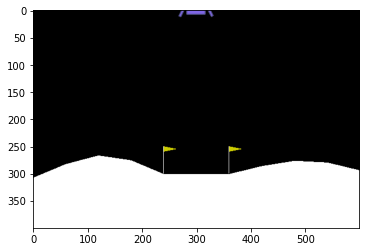

In [3]:
env = make_env('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

In [4]:
def save_checkpoint(state, filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, q_optimizer, policy_optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])

In [5]:
env_name = 'LunarLanderContinuous-v2'
agent, q_optimizer, policy_optimizer, val_ep_rets_arr, val_ep_lens_arr = ddpg_train_val(lambda : make_env(env_name), seed=0, steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99, polyak=0.995, 
        policy_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, update_after=1000, update_every=50, act_noise=0.1, num_val_episodes=10, max_ep_len=1000)

Epoch: 1, Training Average Reward: -219, Training Average Length: 105
Epoch: 1, Val Average Reward: -208, Val Average Length: 640
Epoch: 2, Training Average Reward: -233, Training Average Length: 104
Epoch: 2, Val Average Reward: 37, Val Average Length: 401
Epoch: 3, Training Average Reward: -201, Training Average Length: 132
Epoch: 3, Val Average Reward: -241, Val Average Length: 164
Epoch: 4, Training Average Reward: -35, Training Average Length: 236
Epoch: 4, Val Average Reward: -39, Val Average Length: 250
Epoch: 5, Training Average Reward: -174, Training Average Length: 407
Epoch: 5, Val Average Reward: -292, Val Average Length: 516
Epoch: 6, Training Average Reward: -60, Training Average Length: 495
Epoch: 6, Val Average Reward: -185, Val Average Length: 393
Epoch: 7, Training Average Reward: -224, Training Average Length: 566
Epoch: 7, Val Average Reward: -199, Val Average Length: 373
Epoch: 8, Training Average Reward: -189, Training Average Length: 448
Epoch: 8, Val Average Rew

In [18]:
checkpoint = {
    "state_dict": agent.state_dict(), 
    "q-optimizer": q_optimizer.state_dict(),
    "policy_optimizer": policy_optimizer.state_dict(),}
save_checkpoint(checkpoint, 'models/trained_gamma099qlr00001plr00001.pth.tar')

=> Saving checkpoint


In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [11]:
ep_rets, ep_lens, avg_test_ep_rets, avg_test_ep_lens = test_agent(env, agent, 100, 1000)
test_ep_rets = running_mean(ep_rets, 10)

In [22]:
pickle.dump(ep_rets, open('results/task3/ep_rets_trained_gamma099qlr00001plr00001'+'.ddpg', 'wb'), -1)         # saving the results for rewards per test episode 100 epochs, gamma 0.99 qlr 0.0001 plr 0.0001

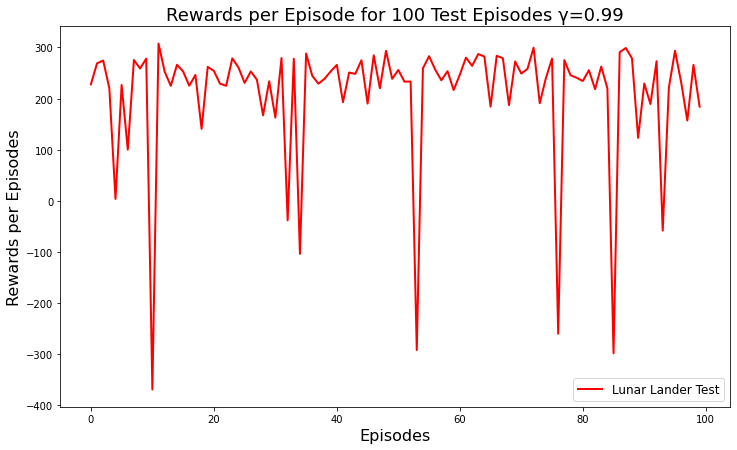

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(0, 100, 1), ep_rets, 'r', linewidth=2.0, label='Lunar Lander Test')
plt.title('Rewards per Episode for 100 Test Episodes γ=0.99', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Rewards per Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.savefig('results/task3/rewardstrained_gamma099qlr00001plr00001')
plt.show()

In [24]:
def generate_animation(env, agent, save_dir):
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state, done, ep_ret, ep_len = env.reset(), False, 0, 0
    while not done:
        state, reward, done, _ = env.step(agent.get_action(state, 0)) # take deterministic actions at test time (noise_scale=0)
        ep_ret += reward
        ep_len += 1

    print('Reward: {}'.format(ep_ret))
    env.close()
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [38]:
save_dir='results/task3/animation'            # animation of learned policy
env = gym.make(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)             # video file is in the directory if not working on notebook

Reward: 256.9759361179502
